# Model 1 — Technical Wine Quality Prediction

This notebook develops the first machine learning model of the project, aimed at predicting technical wine quality based on physicochemical properties.

The objective is not to maximize predictive performance, but to:
- Establish a reliable baseline model
- Identify the most influential chemical features
- Build an interpretable reference for strategic comparison with market perception


## 1. Problem framing

This is a supervised regression problem where the goal is to predict a continuous quality score based solely on chemical composition.

- Target variable: `quality`
- Model type: regression
- Focus: interpretability over complexity


In [1]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [2]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]


## 2. Data loading

The Wine Quality dataset is loaded as the source of analytical quality measurements derived from chemical composition.


In [3]:
wine_quality = pd.read_csv(RAW_PATH / WINE_QUALITY_FILE)
wine_quality.head()



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


## 3. Feature and target definition

All physicochemical variables are used as features.
The quality score is used as the prediction target.


In [28]:
X = wine_quality.drop(columns=["quality", "Id"], errors="ignore")
y = wine_quality["quality"]

X.shape, y.shape


((1143, 11), (1143,))

## 4. Train-test split

The dataset is split into training and testing sets to evaluate generalization performance.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Baseline regression model (cleaned)

This baseline model is trained on the full dataset using physicochemical features only,
after removing irrelevant identifiers. It serves as a reference point for evaluating
the impact of alcohol-aware modeling.


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

rmse_base = -cross_val_score(
    pipe_ridge,
    X,
    y,
    scoring="neg_root_mean_squared_error",
    cv=5
).mean()

r2_base = cross_val_score(
    pipe_ridge,
    X,
    y,
    scoring="r2",
    cv=5
).mean()

rmse_base, r2_base


(np.float64(0.6525886954193305), np.float64(0.3114500828868461))

## Alcohol-aware global model

Based on prior segmentation analysis, alcohol is known to define distinct quality regimes.
This model incorporates alcohol range information to capture non-linear structural effects
within a single global model.


In [33]:
if "alcohol_segment_3" not in wine_quality.columns:
    wine_quality["alcohol_segment_3"] = pd.cut(
        wine_quality["alcohol"],
        bins=[0, 10, 12, float("inf")],
        labels=["<10%", "10–12%", ">12%"],
        right=False
    )


In [34]:
X_seg = X.copy()
X_seg["alcohol_segment"] = wine_quality["alcohol_segment_3"]

X_seg = pd.get_dummies(X_seg, drop_first=True)

rmse_seg = -cross_val_score(
    pipe_ridge,
    X_seg,
    y,
    scoring="neg_root_mean_squared_error",
    cv=5
).mean()

r2_seg = cross_val_score(
    pipe_ridge,
    X_seg,
    y,
    scoring="r2",
    cv=5
).mean()

rmse_seg, r2_seg


(np.float64(0.6537203264626634), np.float64(0.3091947269558017))

## Segment-specific regression models (exploratory)

To further assess whether chemical-quality relationships differ structurally across
alcohol regimes, separate regression models are trained for each alcohol segment.
These models are not intended for production, but for diagnostic insight.


In [35]:
results_by_segment = {}

for segment in ["<10%", "10–12%", ">12%"]:
    df_seg = wine_quality[wine_quality["alcohol_segment_3"] == segment]
    X_s = df_seg.drop(columns=["quality", "alcohol_segment_3"], errors="ignore")
    y_s = df_seg["quality"]
    
    rmse_s = -cross_val_score(
        pipe_ridge,
        X_s,
        y_s,
        scoring="neg_root_mean_squared_error",
        cv=5
    ).mean()
    
    results_by_segment[segment] = rmse_s

results_by_segment


{'<10%': np.float64(0.5814826466304167),
 '10–12%': np.float64(0.6711409149542272),
 '>12%': np.float64(0.8460181264562483)}

## Model comparison and interpretation

Model performance is compared across:
- a cleaned global baseline
- an alcohol-aware global model
- segment-specific exploratory models

The goal is not solely to optimize RMSE, but to assess stability and interpretability
in preparation for scenario simulation and risk modeling.


## 5. Baseline model: Linear Regression

A linear regression model is used as a transparent baseline to understand how chemical variables relate to wine quality.


In [6]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

r2_lr = r2_score(y_test, y_pred_lr)

rmse_lr, r2_lr


(np.float64(0.6184079172594739), 0.31276385395081274)

## 6. Regularized model: Ridge Regression

Ridge regression is applied to control coefficient magnitude and mitigate multicollinearity among chemical features.


In [7]:
ridge_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=1.0))
    ]
)

ridge_pipeline.fit(X_train, y_train)

y_pred_ridge = ridge_pipeline.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_ridge, r2_ridge


(np.float64(0.6182885935086545), 0.3130290371120601)

## 7. Model comparison

Both models are compared using RMSE and R² to assess performance stability and suitability as a technical quality baseline.


In [8]:
pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression"],
    "RMSE": [rmse_lr, rmse_ridge],
    "R2": [r2_lr, r2_ridge]
})


,Model,RMSE,R2
0,Linear Regression,0.618408,0.312764
1,Ridge Regression,0.618289,0.313029


## 8. Feature importance and interpretation

Model coefficients are analyzed to identify which chemical properties are most strongly associated with technical wine quality.


In [9]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lin_reg.coef_
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
9,sulphates,0.953929
10,alcohol,0.271614
0,fixed acidity,0.044828
3,residual sugar,0.004647
5,free sulfur dioxide,0.002789
11,Id,-0.000072
6,total sulfur dioxide,-0.002587
8,pH,-0.284072
2,citric acid,-0.320227
1,volatile acidity,-1.326510


## 9. Technical interpretation

The model highlights a small number of physicochemical variables that drive technical quality scores.
These variables provide a quantitative link between grape composition and expert evaluation.

This model will serve as the technical benchmark when compared against market perception models in later stages.


## 10. Visualization of feature influence on technical quality

To support interpretation and communication, model coefficients are visualized to highlight which chemical properties are most strongly associated with higher or lower quality scores.

This visualization helps translate statistical results into an intuitive narrative suitable for business and non-technical audiences.


In [10]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lin_reg.coef_
}).sort_values(by="coefficient")


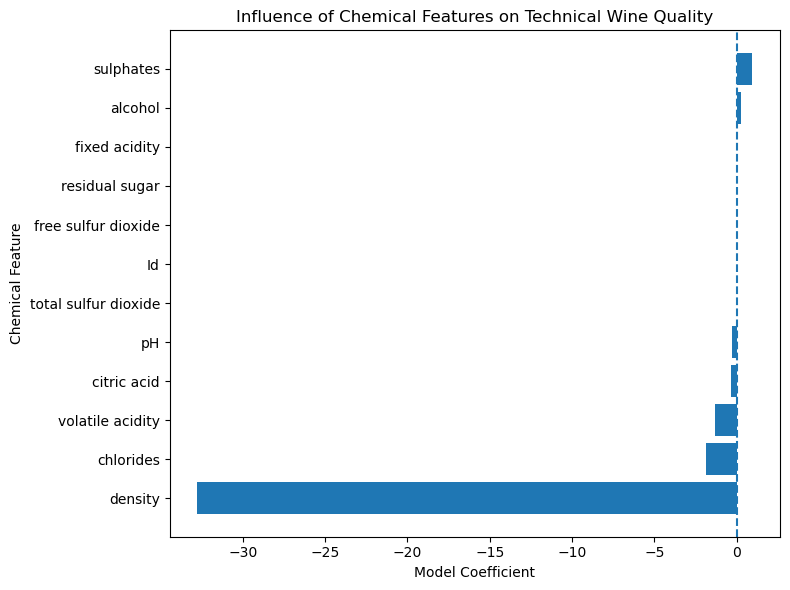

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.barh(
    coef_df["feature"],
    coef_df["coefficient"]
)

plt.axvline(0, linestyle="--")
plt.title("Influence of Chemical Features on Technical Wine Quality")
plt.xlabel("Model Coefficient")
plt.ylabel("Chemical Feature")

plt.tight_layout()
plt.show()


In [12]:
plt.savefig("../figures/technical_quality_coefficients.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

## 10. Model validation and robustness checks

After establishing a baseline technical quality model, advanced machine learning techniques are applied to validate robustness, assess stability, and benchmark performance.

The goal of this section is not model optimization, but to ensure that the identified chemical drivers of quality are stable and reliable.







## 11. Cross-validation

Cross-validation is used to evaluate model stability across different train-test splits and to ensure that results are not dependent on a single random split.


In [13]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

lin_reg_cv_rmse = np.sqrt(
    -cross_val_score(
        lin_reg,
        X,
        y,
        scoring="neg_mean_squared_error",
        cv=cv
    )
)

lin_reg_cv_rmse.mean(), lin_reg_cv_rmse.std()


(np.float64(0.6451116271454198), np.float64(0.02950038767907933))

## 12. Regularization comparison

Regularization techniques are used to control coefficient magnitude and assess feature stability under penalization.


In [14]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01)

ridge_cv_rmse = np.sqrt(
    -cross_val_score(
        ridge,
        X,
        y,
        scoring="neg_mean_squared_error",
        cv=cv
    )
)

lasso_cv_rmse = np.sqrt(
    -cross_val_score(
        lasso,
        X,
        y,
        scoring="neg_mean_squared_error",
        cv=cv
    )
)

(
    ridge_cv_rmse.mean(), ridge_cv_rmse.std(),
    lasso_cv_rmse.mean(), lasso_cv_rmse.std()
)


(np.float64(0.64488305175551),
 np.float64(0.03219278331029671),
 np.float64(0.6506607933281219),
 np.float64(0.038509444409042394))

## 13. Coefficient stability analysis

Coefficient stability across models is analyzed to confirm whether the same chemical features consistently influence technical quality.


In [15]:
coef_comparison = pd.DataFrame({
    "feature": X.columns,
    "linear": lin_reg.coef_,
    "ridge": ridge.fit(X, y).coef_,
    "lasso": lasso.fit(X, y).coef_
})

coef_comparison


,feature,linear,ridge,lasso
0,fixed acidity,0.044828,0.008317,0.032171
1,volatile acidity,-1.326510,-1.145895,-0.926894
2,citric acid,-0.320227,-0.146766,0.000000
3,residual sugar,0.004647,0.003788,-0.000000
4,chlorides,-1.836925,-1.094745,-0.000000
5,free sulfur dioxide,0.002789,0.002915,0.003035
6,total sulfur dioxide,-0.002587,-0.002881,-0.002722
7,density,-32.767833,-0.016057,-0.000000
8,pH,-0.284072,-0.446978,-0.000000
9,sulphates,0.953929,0.753783,0.359826


## 14. Non-linear benchmark model

A Random Forest model is used as a non-linear benchmark to assess whether complex interactions significantly improve predictive performance.


In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=6
)

rf_cv_rmse = np.sqrt(
    -cross_val_score(
        rf,
        X,
        y,
        scoring="neg_mean_squared_error",
        cv=cv
    )
)

rf_cv_rmse.mean(), rf_cv_rmse.std()


(np.float64(0.6145371883730153), np.float64(0.037521417227289584))

## 15. Feature importance comparison

Feature importance from the Random Forest model is compared with linear coefficients to validate consistency of key drivers.


In [17]:
rf.fit(X, y)

rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

rf_importance


,feature,importance
10,alcohol,0.385195
9,sulphates,0.156774
1,volatile acidity,0.143725
6,total sulfur dioxide,0.055325
11,Id,0.041052
0,fixed acidity,0.036891
8,pH,0.036422
2,citric acid,0.033802
7,density,0.030653
4,chlorides,0.028584


## 16. Sensitivity analysis

A sensitivity analysis is performed to observe how changes in key chemical variables affect predicted quality, holding other variables constant.


C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Marta\anaconda3\

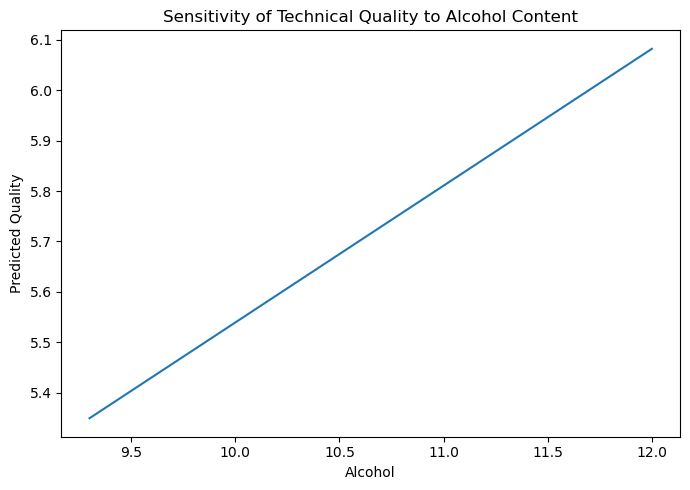

In [18]:
baseline = X.mean()

alcohol_range = np.linspace(
    X["alcohol"].quantile(0.1),
    X["alcohol"].quantile(0.9),
    50
)

predicted_quality = []

for a in alcohol_range:
    sample = baseline.copy()
    sample["alcohol"] = a
    predicted_quality.append(lin_reg.predict([sample])[0])

plt.figure(figsize=(7, 5))
plt.plot(alcohol_range, predicted_quality)
plt.xlabel("Alcohol")
plt.ylabel("Predicted Quality")
plt.title("Sensitivity of Technical Quality to Alcohol Content")
plt.tight_layout()
plt.show()


## 17. Comparison of feature relevance across model families

Different model families capture different aspects of the relationship between chemical composition and technical wine quality.

To better understand these differences, we visually compare:
- Linear model coefficients (directional effects)
- Random Forest feature importance (informational value)

This comparison highlights how feature relevance changes depending on the modeling assumptions.


In [19]:
linear_coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lin_reg.coef_
}).sort_values(by="coefficient")


In [20]:
rf_importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance")


### Linear regression coefficients

This chart shows the direction and relative magnitude of each feature's association with technical wine quality.
Negative values indicate a penalizing effect, while positive values indicate a favorable association.


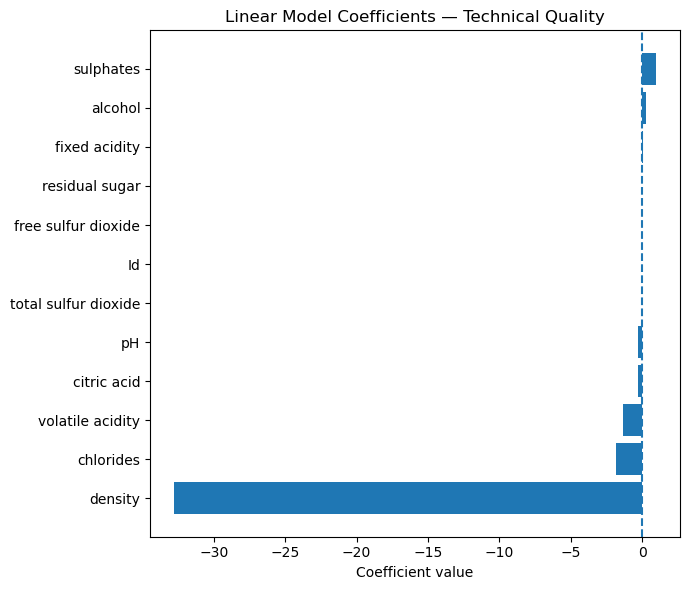

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

plt.barh(
    linear_coef_df["feature"],
    linear_coef_df["coefficient"]
)

plt.axvline(0, linestyle="--")
plt.xlabel("Coefficient value")
plt.title("Linear Model Coefficients — Technical Quality")

plt.tight_layout()
plt.show()


### Random Forest feature importance

This chart displays how informative each feature is for predicting technical quality in a non-linear model.
Values represent relative importance and do not indicate direction.


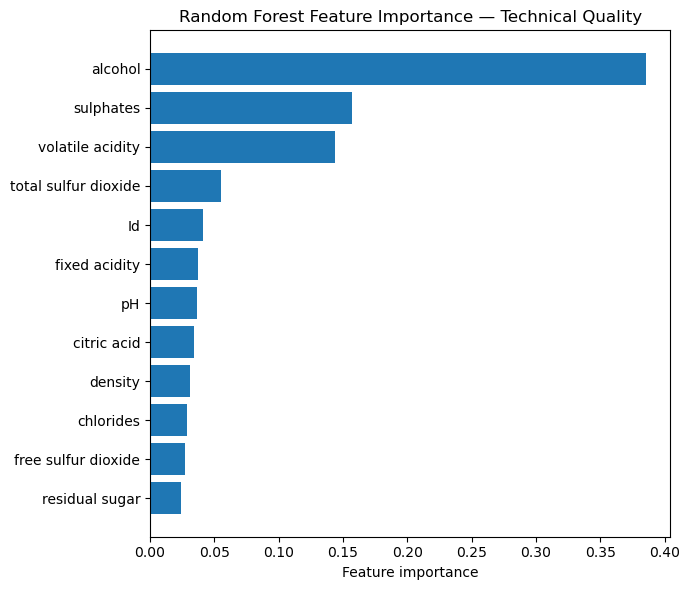

In [22]:
plt.figure(figsize=(7, 6))

plt.barh(
    rf_importance_df["feature"],
    rf_importance_df["importance"]
)

plt.xlabel("Feature importance")
plt.title("Random Forest Feature Importance — Technical Quality")

plt.tight_layout()
plt.show()


## 18. Interpretation of differences

The linear model highlights features with strong directional associations, such as volatile acidity, chlorides, and density, which consistently penalize technical quality as their values increase.

The Random Forest model emphasizes features that best separate wines of different quality levels, with alcohol and sulphates emerging as dominant drivers, and volatile acidity remaining among the most informative variables.

While the relative ordering of features differs across models, there is no contradiction between them. Instead, each model family provides a complementary perspective on how chemical properties relate to technical quality.


## 19. Coefficient comparison across linear models

To assess feature stability and the impact of regularization, coefficients from Linear, Ridge, and Lasso models are compared.

Note that coefficient magnitudes are not directly comparable across features without standardization.


In [23]:
    coef_long = coef_comparison.melt(
    id_vars="feature",
    value_vars=["linear", "ridge", "lasso"],
    var_name="model",
    value_name="coefficient"
)


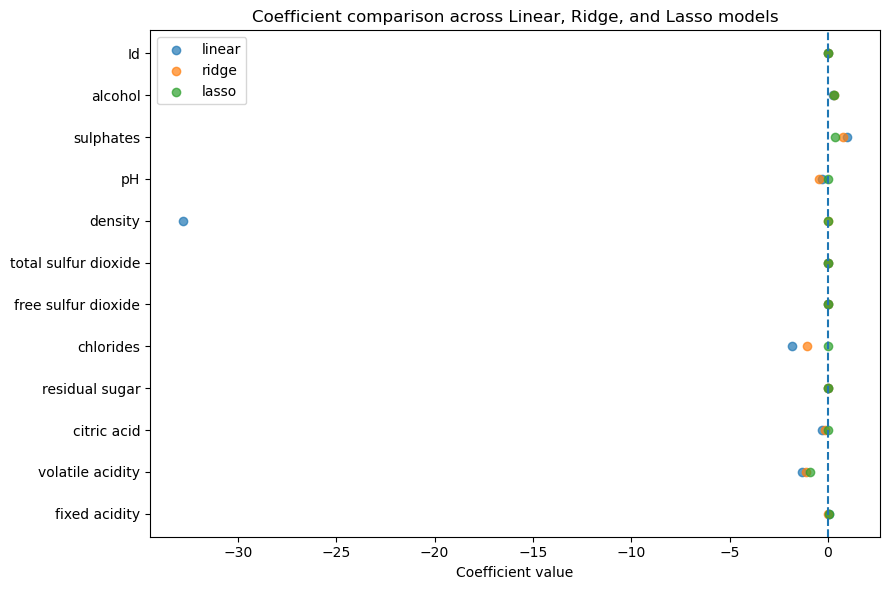

In [24]:
plt.figure(figsize=(9, 6))

for model in coef_long["model"].unique():
    subset = coef_long[coef_long["model"] == model]
    plt.scatter(
        subset["coefficient"],
        subset["feature"],
        label=model,
        alpha=0.7
    )

plt.axvline(0, linestyle="--")
plt.xlabel("Coefficient value")
plt.title("Coefficient comparison across Linear, Ridge, and Lasso models")
plt.legend()
plt.tight_layout()
plt.show()


## 20. Standardized coefficients (Linear Regression)

To enable meaningful comparison across features, variables are standardized and coefficients are re-estimated.


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaled_linear = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression())
    ]
)

scaled_linear.fit(X, y)

scaled_coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": scaled_linear.named_steps["regressor"].coef_
}).sort_values(by="coefficient")


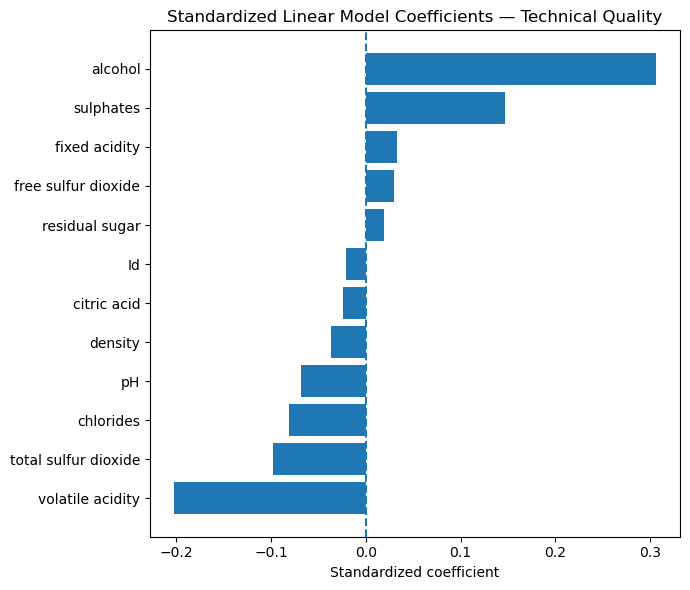

In [26]:
plt.figure(figsize=(7, 6))

plt.barh(
    scaled_coef_df["feature"],
    scaled_coef_df["coefficient"]
)

plt.axvline(0, linestyle="--")
plt.xlabel("Standardized coefficient")
plt.title("Standardized Linear Model Coefficients — Technical Quality")

plt.tight_layout()
plt.show()


Density exhibits a very large coefficient in the unscaled linear model due to its narrow numeric range. After regularization and standardization, its relative importance decreases substantially, indicating that density does not provide independent explanatory power beyond correlated chemical variables.

Regularization techniques (Ridge and Lasso) consistently shrink or eliminate density, reinforcing the conclusion that its apparent dominance in the unscaled model is a scaling artifact rather than a meaningful driver of technical quality.



## 21. Baseline global model (all data, alcohol included)


“How well can we predict quality using all chemical features, including alcohol?”

This baseline model is trained on the full dataset, using all chemical features including alcohol.
It serves as a benchmark to evaluate the impact of alcohol control and segmentation in later experiments.


In [36]:
# Features and target
X = wine_quality.drop(columns=["quality"])
y = wine_quality["quality"]


In [38]:
# Define feature columns (only numeric chemical variables)
feature_cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

X = wine_quality[feature_cols]
y = wine_quality["quality"]


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred = ridge.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline Ridge - R2: {r2:.3f}")
print(f"Baseline Ridge - RMSE: {rmse:.3f}")



Baseline Ridge - R2: 0.317
Baseline Ridge - RMSE: 0.616


In [40]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": ridge.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_df


,feature,coefficient
10,alcohol,0.285819
1,volatile acidity,-0.238646
9,sulphates,0.161463
0,fixed acidity,0.086838
4,chlorides,-0.085712
6,total sulfur dioxide,-0.072929
2,citric acid,-0.065283
7,density,-0.058945
8,pH,-0.037865
5,free sulfur dioxide,0.019222


“The global baseline model achieves an R² of 0.32, which is consistent with the noisy and subjective nature of wine quality ratings. Alcohol emerges as the dominant predictor, indicating that global models largely capture a general alcohol–quality trend rather than finer chemical differences. This motivates further experiments controlling for alcohol to assess whether chemical features provide additional predictive signal.”

## 22. Model with controlled alcohol range (10–12%, alcohol excluded)


In this experiment, the dataset is restricted to wines with alcohol content between 10% and 12%.
Alcohol is excluded as a feature in order to assess whether other chemical variables can explain
quality differences once alcohol is controlled for.


In [41]:
wine_10_12 = wine_quality[
    (wine_quality["alcohol"] >= 10) &
    (wine_quality["alcohol"] < 12)
].copy()

wine_10_12.shape


(536, 14)

In [42]:
feature_cols_no_alcohol = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates"
]

X = wine_10_12[feature_cols_no_alcohol]
y = wine_10_12["quality"]


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_10_12 = Ridge(alpha=1.0)
ridge_10_12.fit(X_train_scaled, y_train)

y_pred = ridge_10_12.predict(X_test_scaled)

r2_10_12 = r2_score(y_test, y_pred)
rmse_10_12 = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Ridge 10–12% (no alcohol) - R2: {r2_10_12:.3f}")
print(f"Ridge 10–12% (no alcohol) - RMSE: {rmse_10_12:.3f}")


Ridge 10–12% (no alcohol) - R2: 0.134
Ridge 10–12% (no alcohol) - RMSE: 0.756


In [44]:
coef_10_12 = pd.DataFrame({
    "feature": X.columns,
    "coefficient": ridge_10_12.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_10_12


,feature,coefficient
6,total sulfur dioxide,-0.231574
9,sulphates,0.194574
7,density,-0.190861
1,volatile acidity,-0.189675
5,free sulfur dioxide,0.171853
8,pH,-0.110674
0,fixed acidity,0.070464
3,residual sugar,0.062473
4,chlorides,-0.034570
2,citric acid,0.029476


## 23. Model within 10–12% alcohol range (alcohol included)


In [45]:
# Features INCLUDING alcohol
feature_cols_with_alcohol = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

X = wine_10_12[feature_cols_with_alcohol]
y = wine_10_12["quality"]


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_10_12 = Ridge(alpha=1.0)
ridge_10_12.fit(X_train_scaled, y_train)

y_pred = ridge_10_12.predict(X_test_scaled)

r2_10_12 = r2_score(y_test, y_pred)
rmse_10_12 = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Ridge 10–12%  - R2: {r2_10_12:.3f}")
print(f"Ridge 10–12%  - RMSE: {rmse_10_12:.3f}")

Ridge 10–12%  - R2: 0.175
Ridge 10–12%  - RMSE: 0.738


In [48]:
coef_10_12 = pd.DataFrame({
    "feature": X.columns,
    "coefficient": ridge_10_12.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_10_12

,feature,coefficient
1,volatile acidity,-0.210414
6,total sulfur dioxide,-0.210376
8,pH,-0.176903
9,sulphates,0.170526
5,free sulfur dioxide,0.169245
10,alcohol,0.153346
0,fixed acidity,-0.067114
4,chlorides,-0.030059
7,density,-0.023312
2,citric acid,-0.006251


“Three Ridge regression models were compared to assess the role of alcohol in predicting wine quality. A global model achieved the highest predictive performance, largely driven by alcohol. When restricting the analysis to wines with 10–12% alcohol, predictive performance decreased, reflecting reduced target variability. Including alcohol within this restricted range improved performance relative to a chemistry-only model, but did not recover global performance levels. This confirms that alcohol acts as a dominant global driver while its marginal contribution diminishes within a controlled range, where other chemical features gain relevance.”

“Within the 10–12% alcohol range, alcohol is no longer the dominant predictor of wine quality. Instead, volatile acidity, sulfur-related variables, pH, and sulphates show stronger associations with quality. This indicates that alcohol primarily drives global variation, while chemical composition explains quality differences among wines with similar alcohol levels.”

“This plot explains our modeling results. In the global model, alcohol dominates because it separates low-quality wines from the rest. When we restrict the analysis to the dense 10–12% range, alcohol loses dominance and chemical variables become more relevant, as shown by the segment-specific models.”

In [50]:
count_below_10 = (wine_quality["alcohol"] < 10).sum()
count_10_12 = ((wine_quality["alcohol"] >= 10) & (wine_quality["alcohol"] < 12)).sum()
count_above_12 = (wine_quality["alcohol"] >= 12).sum()

count_below_10, count_10_12, count_above_12


(np.int64(485), np.int64(536), np.int64(122))

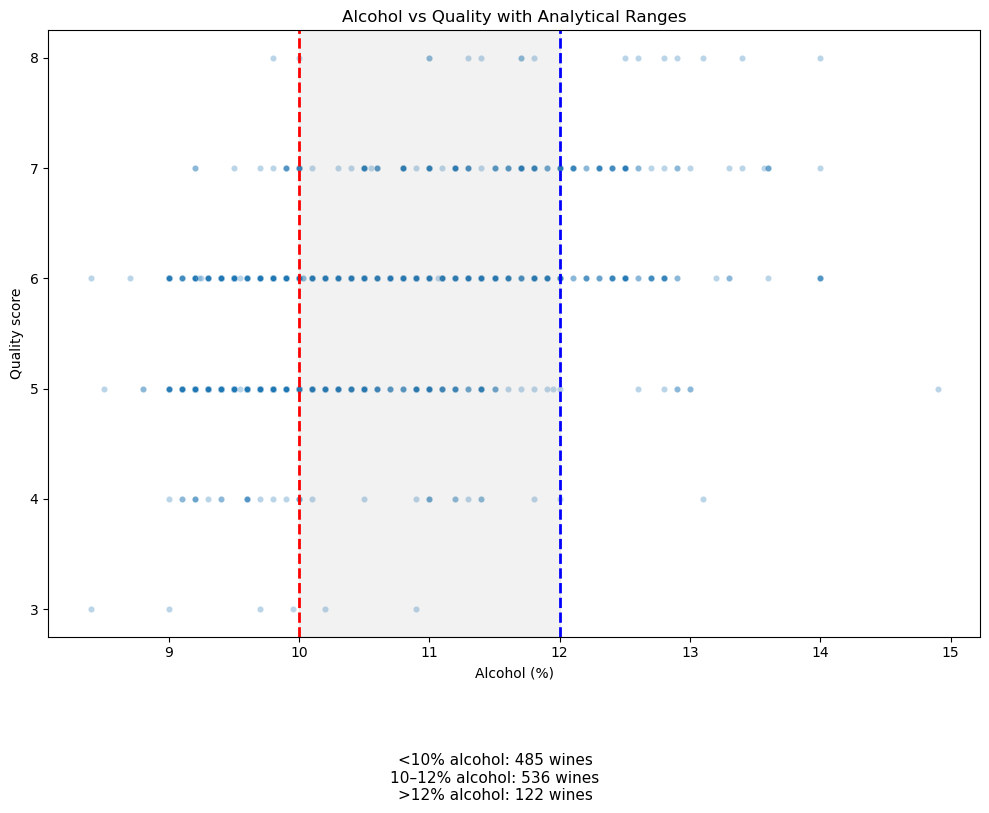

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Counts by alcohol range
count_below_10 = (wine_quality["alcohol"] < 10).sum()
count_10_12 = ((wine_quality["alcohol"] >= 10) & (wine_quality["alcohol"] < 12)).sum()
count_above_12 = (wine_quality["alcohol"] >= 12).sum()

plt.figure(figsize=(10,7))

# Scatter plot
sns.scatterplot(
    data=wine_quality,
    x="alcohol",
    y="quality",
    alpha=0.3,
    s=20
)

# Vertical reference lines
plt.axvline(10, color="red", linestyle="--", linewidth=2)
plt.axvline(12, color="blue", linestyle="--", linewidth=2)

# Highlight focus range
plt.axvspan(10, 12, color="grey", alpha=0.1)

plt.title("Alcohol vs Quality with Analytical Ranges")
plt.xlabel("Alcohol (%)")
plt.ylabel("Quality score")

# Text box with counts (below plot)
textstr = (
    f"<10% alcohol: {count_below_10} wines\n"
    f"10–12% alcohol: {count_10_12} wines\n"
    f">12% alcohol: {count_above_12} wines"
)

plt.gcf().text(
    0.5, -0.15,
    textstr,
    ha="center",
    fontsize=11
)

plt.tight_layout()
plt.show()
